In [29]:
from qibo.gates import I, X, RX, RY, M, CZ
import numpy as np
from qibo.models import Circuit

from utils.qst_qpt_helper_functions import *

from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration

import os

import matplotlib.pyplot as plt
from seaborn import heatmap
from pandas import DataFrame


api = API(ConnectionConfiguration(username="apalacios", api_key="3ec51562-3ff2-4f7b-add8-b21e1645a89d"))
# api = API(ConnectionConfiguration(username="qat", api_key="meow"))


api.select_device_id(9)

#### Constants

In [30]:
NUM_SHOTS = 1000

#### Define basic gate sequence

In [31]:
def six_operators(qubit):
    return [
        I(qubit),
        X(qubit),
        RX(qubit, np.pi / 2),
        RX(qubit, -np.pi / 2),
        RY(qubit, np.pi / 2),
        RY(qubit, -np.pi / 2),
    ]

#### Define circuits for process tomography of the CZ gate and for obtaining the SPAM matrix

In [32]:
def process_tomography(pa, qubit_a, qubit_b):
    """Returns tomography circuits for the 6 different states in qubit B.

    Args:
        pa (qibo.gates.gates): gate assigning the preparation of qubit A.
        qubit_a (int_): first qubit
        qubit_b (int): second qubit

    Returns:
        circuits: list containing the generated tomography circuits.
    """
    circuits = []

    for pb in six_operators(qubit_b):
        for op1_a in six_operators(qubit_a):
            for op1_b in six_operators(qubit_b):
                circuit = Circuit(5)
                circuit.add(pa)  # PA
                circuit.add(pb)  # PB
                circuit.add(CZ(qubit_a, qubit_b))
                circuit.add(op1_a)  # RA
                circuit.add(op1_b)  # RB
                circuit.add(M(qubit_a, qubit_b))

                circuits.append(circuit)
    return circuits


def spam_matrix_circuits(qubit_a, qubit_b):
    circuits = []
    for gate_a in [I, X]:
        for gate_b in [I, X]:
            circuit = Circuit(5)
            circuit.add(gate_a(qubit_a))
            circuit.add(gate_b(qubit_b))
            circuit.add(M(qubit_a, qubit_b))

            circuits.append(circuit)

    return circuits

#### Run sequences
We separate the data coming from each post-CZ basis state reconstruction in order to go around the 1000 circuit limit 
per job.

In [33]:
qubit_pairs = [(0, 2), (1, 2), (2, 3), (2, 4)]

spam_job_ids = {}
qpt_job_ids = {}


# os.environ["QIBOCONNECTION_TIMEOUT"] = "300"
## Uncomment the previous cell if qiboconnection gives a timeout error, may happen if IFAE's network is running slow

for qubit_pair in qubit_pairs:
    QUBIT_A, QUBIT_B = qubit_pair

    ## Run SPAM measurements, store ID
    spam_circuits = spam_matrix_circuits(QUBIT_A, QUBIT_B)
    result_id = api.execute(spam_circuits, nshots=NUM_SHOTS)[0]
    spam_job_ids[str(qubit_pair)] = result_id

    qst_jobids = {}

    ## Run QPT measurements, store ID
    for i, pa in enumerate(six_operators(QUBIT_A)):
        state_tomography_circuits = process_tomography(pa, QUBIT_A, QUBIT_B)
        result_id = api.execute(state_tomography_circuits, nshots=NUM_SHOTS)[0]

        qst_jobids[str(i)] = result_id

    qpt_job_ids[str(qubit_pair)] = qst_jobids

#### Save job ids in .txt

In [34]:
fpath_saveids = "data_stored_here.txt"
print("saved IDs in", fpath_saveids)

## actually save IDs
with open(fpath_saveids, "w") as f:
    for qubit_pair in qubit_pairs:
        f.write("####" + str(qubit_pair) + "\n")
        f.write("spam" + "\t" + str(spam_job_ids[str(qubit_pair)]) + "\n")

        f.write("qpt" + "\t")
        for x in qpt_job_ids[str(qubit_pair)].values():
            f.write(str(x) + "\t")
        f.write("\n")

saved IDs in data_stored_here.txt


#### Retrieve jobs from .txt

In [59]:
fpath_saveids = "data_stored_here.txt"  # _21wasfine.txt"

In [60]:
def retrieve_jobids(fpath_saveids):
    spam_job_ids = {}
    qpt_job_ids = {}
    with open(fpath_saveids, "r") as f:
        for line in f.readlines():
            if line[:4] == "####":
                qubit_pair = (int(line[5]), int(line[8]))
            elif line[:4] == "spam":
                spam_job_ids[str(qubit_pair)] = int(line[5:-1])
            elif line[:3] == "qpt":
                qst_jobids = {}
                for i, x in enumerate(line.split("\t")[1:-1]):
                    qst_jobids[str(i)] = int(x)
                qpt_job_ids[str(qubit_pair)] = qst_jobids
    return spam_job_ids, qpt_job_ids


spam_job_ids, qpt_job_ids = retrieve_jobids(fpath_saveids)

### Analyse data

In [7]:
api.get_job(7780).logs

Your job with id 7780 failed.


'Interruption in stage=\'execute\': \'default\' (<class \'KeyError\'>). Traceback:\n  File "/home/qili-docker/qgqs/services/device_service/src/utils/decorators.py", line 20, in wrapper\n    return func(*args, **kwargs)\n\n  File "/home/qili-docker/qgqs/services/device_service/src/api/slurm_executions.py", line 70, in _execute\n    return execution_class.execute_circuit(\n\n  File "/home/qili-docker/qgqs/services/device_service/src/service/executions/qililab_executions.py", line 46, in execute_circuit\n    results = ql.execute(\n\n  File "/home/qili-docker/miniconda3/envs/submitit/lib/python3.10/site-packages/qililab/execute_circuit.py", line 79, in execute\n    raise e\n\n  File "/home/qili-docker/miniconda3/envs/submitit/lib/python3.10/site-packages/qililab/execute_circuit.py", line 74, in execute\n    results.append(platform.execute(circuit, num_avg=1, repetition_duration=200_000, num_bins=nshots))\n\n  File "/home/qili-docker/miniconda3/envs/submitit/lib/python3.10/site-packages/qil

In [97]:
api.list_jobs().dataframe[:10]

,user_id,device_id,status,job_type,number_shots,id
0,86,9,completed,circuit,1000,7910
1,86,9,completed,circuit,1000,7909
2,86,9,completed,circuit,1000,7908
3,86,9,completed,circuit,1000,7907
4,86,9,completed,circuit,1000,7906
5,86,9,completed,circuit,1000,7905
6,86,9,completed,circuit,1000,7904
7,86,9,completed,circuit,1000,7903
8,86,9,completed,circuit,1000,7902
9,86,9,completed,circuit,1000,7901


In [98]:
qubit_pairs = [(0, 2), (1, 2), (2, 3), (2, 4)]

state_reconstruction_paulibasis = np.zeros((len(qubit_pairs), 36, 16))

ideal_operator = CZ(0, 1).matrix
R_ideal = get_ideal_R_matrix(ideal_operator)

reconstructed_Rs = np.zeros((len(qubit_pairs), 16, 16))
fidelities = {}


for pair_index, qubit_pair in enumerate(qubit_pairs):
    spam_id = spam_job_ids[str(qubit_pair)]
    # spam_id = 7799 #FIXME:
    spam_results = api.get_result(spam_id)
    spam_data_probabilities = process_returned_dataformat(spam_results, nqubits=2)
    coeffs_mat_spam, ideal_measurements_spam = prepare_linear_system_measurement_calibration(spam_data_probabilities)
    measurement_calibration_weights = np.linalg.solve(coeffs_mat_spam, ideal_measurements_spam).reshape(3, 4)
    measurement_calibration_weights = np.linalg.pinv(measurement_calibration_weights)

    P_index = 0
    for pa_index in range(6):
        qst_pa_id = qpt_job_ids[str(qubit_pair)][str(pa_index)]
        # qst_pa_id = [7800,	7801,	7802,	7803,	7804,	7805][pa_index] #FIXME:
        qst_pa_results = api.get_result(qst_pa_id)
        qst_pa_probabilities = process_returned_dataformat(qst_pa_results, nqubits=2)
        qst_pa_expectedobs = convert_probabilities2measurementops(qst_pa_probabilities)

        for pb_index in range(6):
            qst_papb_expectedobs = qst_pa_expectedobs[pb_index * 36 : 36 * (pb_index + 1)]
            coeff_matrix, independent_term = prepare_linear_system_QST(
                measurement_calibration_weights, qst_papb_expectedobs
            )

            ## solve linear system QST
            reconstructed_state_paulibasis_noII = np.linalg.pinv(coeff_matrix) @ independent_term
            state_reconstruction_paulibasis[pair_index, P_index] = np.append(1 / 4, reconstructed_state_paulibasis_noII)

            P_index += 1

    coeffs_mat, independent_term = prepare_linear_system_QPT(state_reconstruction_paulibasis[pair_index])
    Rvec = np.linalg.pinv(coeffs_mat) @ independent_term
    reconstructed_R = Rvec.reshape(16, 16)
    reconstructed_Rs[pair_index] = reconstructed_R

    process_fidelity = compute_process_fidelity(R_ideal, reconstructed_R)
    fidelities[str(qubit_pair)] = process_fidelity

Your job with id 7883 is completed.
Your job with id 7884 is completed.
Your job with id 7885 is completed.
Your job with id 7886 is completed.
Your job with id 7887 is completed.
Your job with id 7888 is completed.
Your job with id 7889 is completed.
Your job with id 7890 is completed.
Your job with id 7891 is completed.
Your job with id 7892 is completed.
Your job with id 7893 is completed.
Your job with id 7894 is completed.
Your job with id 7895 is completed.
Your job with id 7896 is completed.
Your job with id 7897 is completed.
Your job with id 7898 is completed.
Your job with id 7899 is completed.
Your job with id 7900 is completed.
Your job with id 7901 is completed.
Your job with id 7902 is completed.
Your job with id 7903 is completed.
Your job with id 7904 is completed.
Your job with id 7905 is completed.
Your job with id 7906 is completed.
Your job with id 7907 is completed.
{
  "title": "Unauthorized",
  "status": 401,
  "detail": "JWTExpired: Error verifying the authorisa

In [99]:
print(fidelities)

{'(0, 2)': 0.9203826256707334, '(1, 2)': 0.8500176204317396, '(2, 3)': 0.9349274719931073, '(2, 4)': 0.9920363602362581}


Plot process matrices of each CZ

In [100]:
def plot_R(R_mat, title=None, ax=None, fig=None):
    xlabels = ["II", "IX", "IY", "IZ", "XI", "XX", "XY", "XZ", "YI", "YX", "YY", "YZ", "ZI", "ZX", "ZY", "ZZ"]

    r_df = DataFrame(R_mat * (2**2), index=xlabels, columns=xlabels)
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3))
    ax = heatmap(r_df, vmin=-4, vmax=4, ax=ax)
    if title is not None:
        ax.set_title(title)
    return fig, ax

In [64]:
# galadriel_runcard = api.get_runcard(runcard_name="galadriel")

In [57]:
# galadriel_runcard.runcard

{'buses': [{'alias': 'readout_bus',
   'delay': 0,
   'distortions': [],
   'port': 'feedline_input',
   'system_control': {'instruments': ['QRM1', 'rs_1', 'attenuator'],
    'name': 'readout_system_control'}},
  {'alias': 'drive_q0_bus',
   'delay': 0,
   'distortions': [],
   'port': 'drive_q0',
   'system_control': {'instruments': ['QCM-RF1'], 'name': 'system_control'}},
  {'alias': 'flux_q0_bus',
   'delay': 0,
   'distortions': [],
   'port': 'flux_q0',
   'system_control': {'instruments': ['QCM4'], 'name': 'system_control'}},
  {'alias': 'drive_q1_bus',
   'delay': 0,
   'distortions': [],
   'port': 'drive_q1',
   'system_control': {'instruments': ['QCM-RF1'], 'name': 'system_control'}},
  {'alias': 'flux_q1_bus',
   'delay': 0,
   'distortions': [],
   'port': 'flux_q1',
   'system_control': {'instruments': ['QCM4'], 'name': 'system_control'}},
  {'alias': 'drive_q2_bus',
   'delay': 0,
   'distortions': [],
   'port': 'drive_q2',
   'system_control': {'instruments': ['QCM3', '

In [53]:
from scipy.optimize import minimize
from qibo import gates

reconstructed_R = reconstructed_Rs[3]


def fun2optimise(params):
    alpha, beta = params
    c = Circuit(2)
    c.add(gates.CZ(0, 1))
    c.add(gates.RZ(0, alpha))
    c.add(gates.RZ(1, beta))
    ideal_operator = c.unitary()
    R_ideal = get_ideal_R_matrix(ideal_operator)
    return -compute_process_fidelity(R_ideal, reconstructed_R)


sol = minimize(fun2optimise, x0=(0, 0), bounds=[(-np.pi, np.pi), (-np.pi, np.pi)])

In [54]:
alphaopt, betaopt = sol.x
print(alphaopt, betaopt, "fun", -sol.fun)
optimised_process_fidelity = -sol.fun

0.15647510949960405 0.915290568948229 fun 0.7273201535077339


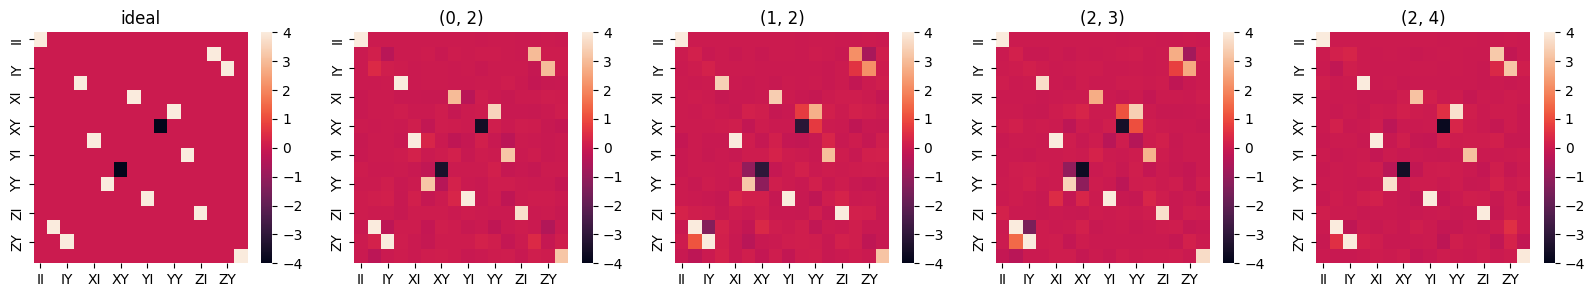

In [101]:
figsize = (3, 3)
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
fig, axes[0] = plot_R(R_ideal, title="ideal", ax=axes[0], fig=fig)
for i in range(4):
    fig, axes[i + 1] = plot_R(reconstructed_Rs[i], title=str(qubit_pairs[i]), ax=axes[i + 1])